In [320]:
import requests
import json
import datetime
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Goal: predict recall percentage by its past values and the historical data of outbreaks.
We implement this using VAR (vector autoregression) (with seasonality?). 

Step 1: data cleaning of the BEAM data by dropping erroneous state entries.

In [321]:
beam = pd.read_csv('beam.csv')
print(beam.head(3))

   Year  Month State Source Type Source Site       Pathogen Serotype/Species  \
0  2025      1    AL      Animal       Other  Campylobacter             coli   
1  2025      1    AL      Animal       Other  Campylobacter           jejuni   
2  2025      1    AL        Food       Other  Campylobacter             coli   

   Number of isolates  Outbreak associated isolates  New multistate outbreaks  \
0                   3                           NaN                       NaN   
1                   1                           NaN                       NaN   
2                  18                           NaN                       NaN   

   New multistate outbreaks - US  \
0                            NaN   
1                            NaN   
2                            NaN   

   % Isolates with clinically important antimicrobial resistance  \
0                                                NaN               
1                                                NaN               
2    

In [322]:
beam['State'].unique()

array(['AL', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'NE', 'NJ', 'NV', 'NY', 'OH', 'OK', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY',
       'AZ', 'HI', 'ME', 'NH', 'NM', 'OR', 'AK', 'ND', 'VI', 'BC', 'N/',
       'US', 'OU', 'CH', 'AU', 'IO', nan, 'NU', 'SO', 'HY', 'OT', '??',
       'GU', 'NO', 'RN', 'AB', 'LL', 'I'], dtype=object)

In [323]:
states = [
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    #"DC",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Inhabited_territories.
    #"AS", "GU", "MP", "PR", "VI",
]

states_dict = {
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC": "District of Columbia",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Inhabited_territories.
    "AS": "American Samoa",
    "GU": "Guam GU",
    "MP": "Northern Mariana Islands",
    "PR": "Puerto Rico PR",
    "VI": "U.S. Virgin Islands",
}


beam_valid_state = beam[beam['State'].isin(states)]
print(len(beam)-len(beam_valid_state))


1403


In [324]:
print(beam[beam['State']=='N/'].head(3))
print(beam[beam['State']=='LL'].head(3))
print(beam[beam['State']=='I'].head(3))
print(beam[beam['State']=='nan'].head(3))

       Year  Month State Source Type Source Site    Pathogen Serotype/Species  \
13810  2024      3    N/       Human       Stool  Salmonella      Enteritidis   
16100  2024      4    N/       Human       Other  Salmonella           Anatum   
16101  2024      4    N/       Human       Other  Salmonella   I 4,[5],12:i:-   

       Number of isolates  Outbreak associated isolates  \
13810                   1                           NaN   
16100                   1                           NaN   
16101                   1                           NaN   

       New multistate outbreaks  New multistate outbreaks - US  \
13810                       NaN                            NaN   
16100                       NaN                            NaN   
16101                       NaN                            NaN   

       % Isolates with clinically important antimicrobial resistance  \
13810                                                NaN               
16100                        

In [325]:
beam = beam_valid_state

In [326]:
beam['Pathogen'].unique()

array(['Campylobacter', 'STEC', 'Salmonella', 'Shigella', 'Vibrio'],
      dtype=object)

Step 2: create the dataframe of the number of outbreaks (filtered by pathogen types). 

In [327]:
beam[['Month','Year']]

,Month,Year
0,1,2025
1,1,2025
2,1,2025
3,1,2025
4,1,2025
...,...,...
209665,12,2018
209666,12,2018
209667,12,2018
209668,12,2018


In [328]:
print(pd.date_range(start='2010-01-01', end='2025-05-31',freq ='ME'))
print(pd.date_range(start='2010-01-01', end='2025-05-31',freq ='ME').to_period('M'))

DatetimeIndex(['2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31',
               ...
               '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31',
               '2025-04-30', '2025-05-31'],
              dtype='datetime64[ns]', length=185, freq='ME')
PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10',
             ...
             '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01',
             '2025-02', '2025-03', '2025-04', '2025-05'],
            dtype='period[M]', length=185)


In [329]:

beam['Day']=np.ones(len(beam)) # we set all days as 1 for our purposes
beam['date']=pd.to_datetime(beam[['Day','Month','Year']])#.dt.to_period('M') #recording year+month
start_date = pd.to_datetime('2018-01-01')#.to_period('M')
end_date = pd.to_datetime('2025-04-30')#.to_period('M')  
#beam = beam[(beam['date'] >= start_date) & (beam['date'] <= end_date)]
#beam.set_index('date', inplace=True)

Pathogens = beam['Pathogen'].unique()

In [330]:
timeframe = pd.date_range(start='2018-01-01', end='2025-04-30',freq ='ME').to_period('M') #note that the data for BEAM are at a different time frame
print(len(timeframe))
outbreak_freq = pd.DataFrame({
    'time': timeframe
}).set_index('time')
#print(beam)
#beam['date']=pd.to_datetime(beam[['Day','Month','Year']])
#print(beam[['date','Pathogen']].value_counts())

#checking that the first/last month have non-zero counts in each pathogen category
for pathogen_name in Pathogens:
    print()
    print(pathogen_name)
    print()
    print(beam[beam['Pathogen']==pathogen_name].groupby(pd.Grouper(key="date", freq="ME")).sum()['Day'])

#.asfreq(freq='ME', fill_value=0) is not needed as there are no missing months in between 
    outbreak_freq.loc[:,pathogen_name] = beam[beam['Pathogen']==pathogen_name].groupby(pd.Grouper(key="date", freq="ME")).sum()['Day'].values

print(outbreak_freq)

88

Campylobacter

date
2018-01-31    143.0
2018-02-28    125.0
2018-03-31    125.0
2018-04-30    132.0
2018-05-31    167.0
              ...  
2024-12-31    143.0
2025-01-31    144.0
2025-02-28    146.0
2025-03-31    149.0
2025-04-30     75.0
Freq: ME, Name: Day, Length: 88, dtype: float64

STEC

date
2018-01-31    246.0
2018-02-28    188.0
2018-03-31    297.0
2018-04-30    333.0
2018-05-31    370.0
              ...  
2024-12-31    374.0
2025-01-31    440.0
2025-02-28    330.0
2025-03-31    463.0
2025-04-30    289.0
Freq: ME, Name: Day, Length: 88, dtype: float64

Salmonella

date
2018-01-31    1487.0
2018-02-28    1307.0
2018-03-31    1538.0
2018-04-30    1564.0
2018-05-31    1882.0
               ...  
2024-12-31    1759.0
2025-01-31    1563.0
2025-02-28    1383.0
2025-03-31    1508.0
2025-04-30    1222.0
Freq: ME, Name: Day, Length: 88, dtype: float64

Shigella

date
2018-01-31    68.0
2018-02-28    61.0
2018-03-31    61.0
2018-04-30    58.0
2018-05-31    56.0
              ... 
2

Step 3: combine monthly_recall_percentage with our data and truncate the timeframe. The resulting dataframe is called "combined_data" 

In [331]:
monthly_recall_percentage = pd.read_csv('monthly_recall_percentage.csv')
print(monthly_recall_percentage)

    Inspection End Month  Recall Percentage
0             2008-10-01          16.593886
1             2008-11-01          14.141414
2             2008-12-01          10.266940
3             2009-01-01          13.342898
4             2009-02-01          19.554031
..                   ...                ...
196           2025-02-01           8.050847
197           2025-03-01           7.468477
198           2025-04-01           6.285178
199           2025-05-01           7.352941
200           2025-06-01           0.000000

[201 rows x 2 columns]


In [332]:
#truncate the timeframe and cleaning format
monthly_recall_percentage['Inspection End Month']=pd.to_datetime(monthly_recall_percentage['Inspection End Month'])
monthly_recall_percentage = monthly_recall_percentage[(monthly_recall_percentage['Inspection End Month']<=end_date)&(monthly_recall_percentage['Inspection End Month']>=start_date)]
print(monthly_recall_percentage)
monthly_recall_percentage['Inspection End Month']=monthly_recall_percentage['Inspection End Month'].apply(lambda x: x.strftime('%Y-%m'))
monthly_recall_percentage.set_index('Inspection End Month', inplace=True)
print(monthly_recall_percentage)

    Inspection End Month  Recall Percentage
111           2018-01-01           8.529742
112           2018-02-01           8.658923
113           2018-03-01           8.655617
114           2018-04-01           6.174089
115           2018-05-01           7.234886
..                   ...                ...
194           2024-12-01           9.337349
195           2025-01-01           8.310992
196           2025-02-01           8.050847
197           2025-03-01           7.468477
198           2025-04-01           6.285178

[88 rows x 2 columns]
                      Recall Percentage
Inspection End Month                   
2018-01                        8.529742
2018-02                        8.658923
2018-03                        8.655617
2018-04                        6.174089
2018-05                        7.234886
...                                 ...
2024-12                        9.337349
2025-01                        8.310992
2025-02                        8.050847
2025-03  

In [333]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [334]:
combined_data = outbreak_freq.reset_index(drop=True)
combined_data['recall']=monthly_recall_percentage['Recall Percentage'].values
print(combined_data)

    Campylobacter   STEC  Salmonella  Shigella  Vibrio    recall
0           143.0  246.0      1487.0      68.0     3.0  8.529742
1           125.0  188.0      1307.0      61.0     3.0  8.658923
2           125.0  297.0      1538.0      61.0     3.0  8.655617
3           132.0  333.0      1564.0      58.0     3.0  6.174089
4           167.0  370.0      1882.0      56.0    10.0  7.234886
..            ...    ...         ...       ...     ...       ...
83          143.0  374.0      1759.0      78.0    11.0  9.337349
84          144.0  440.0      1563.0      80.0     4.0  8.310992
85          146.0  330.0      1383.0      79.0    10.0  8.050847
86          149.0  463.0      1508.0      81.0    10.0  7.468477
87           75.0  289.0      1222.0      62.0     5.0  6.285178

[88 rows x 6 columns]


Step 4: Construct an example VAR model.  

3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     11:08:16
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    34.8357
Nobs:                     85.0000    HQIC:                   32.8773
Log likelihood:          -1950.94    FPE:                5.32330e+13
AIC:                      31.5596    Det(Omega_mle):     1.58670e+13
--------------------------------------------------------------------
Results for equation Campylobacter
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   92.218861        43.278271            2.131           0.033
L1.Campylobacter         0.388240         0.154119            2.519           0.012
L1.STEC                  0.009565     

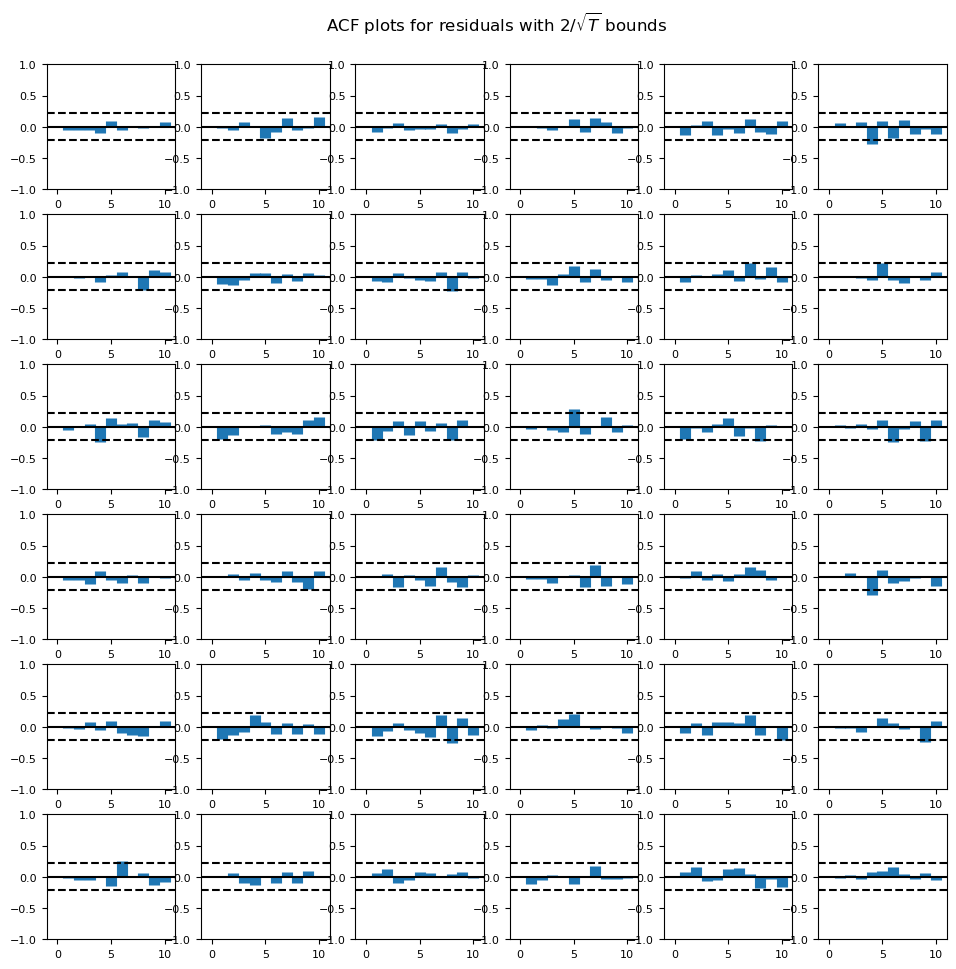

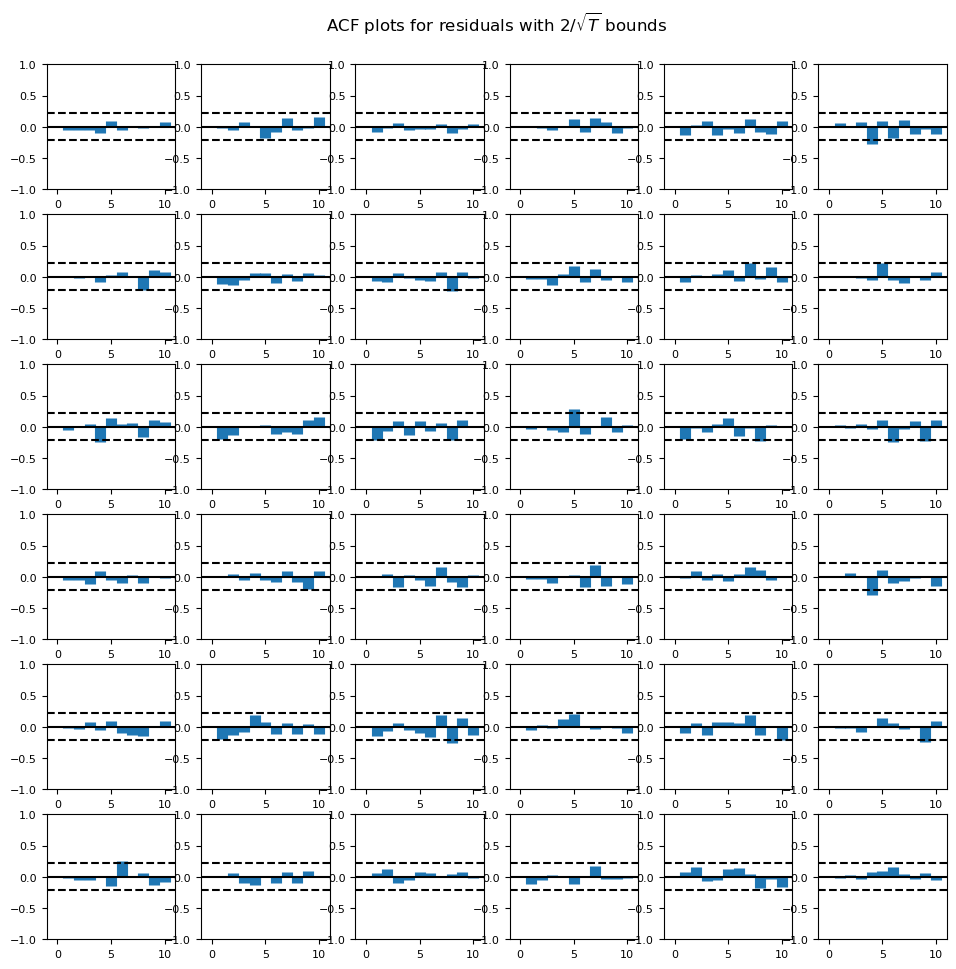

In [335]:
model = VAR(combined_data)
results = model.fit(3)

print(results.k_ar)
print(results.summary())
results.plot_acorr()

Step 5: 
Use kfold split and compare VAR model and the naive model(where we just look at the previous "depth_naive" years and use the seasonal average as the forecast)

In [336]:
from sklearn.model_selection import TimeSeriesSplit

In [337]:
num_forecast = 6
kfold = TimeSeriesSplit(n_splits=5, test_size=num_forecast
                        )
for train_index, test_index in kfold.split(combined_data):
    print('TRAIN INDEX:', train_index)
    print('TEST INDEX:', test_index)
    print()

TRAIN INDEX: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
TEST INDEX: [58 59 60 61 62 63]

TRAIN INDEX: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
TEST INDEX: [64 65 66 67 68 69]

TRAIN INDEX: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
TEST INDEX: [70 71 72 73 74 75]

TRAIN INDEX: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
TEST INDEX: [76 77 78 79 80 

In [338]:
from sklearn.metrics import mean_squared_error as mse

forecast
[[ 168.6023745   252.14209927 1621.08602624   58.31676982   12.95467911
     4.42136044]
 [ 159.91850106  267.77280868 1525.6201091    54.60511751   17.02673024
     5.90018898]
 [ 186.72896544  234.28042084 1396.2322199    57.65549574    9.55115858
     6.95662839]
 [ 176.05412326  285.51191695 1283.27249633   57.19338458    6.5868186
     6.74304817]
 [ 196.36468538  306.75295327 1414.61746559   58.13371492    6.33553447
     6.27136712]
 [ 193.90332291  409.87169583 1587.29286828   58.32255252    8.26039042
     6.2532763 ]]
pred_var
[4.42136044 5.90018898 6.95662839 6.74304817 6.27136712 6.2532763 ]
actual data
58    6.892523
59    7.511046
60    7.238606
61    8.549223
62    7.563025
63    5.022831
Name: recall, dtype: float64
forecast
[[ 162.89188056  496.66626787 1939.71141657   85.30980952   17.17656103
     4.70449266]
 [ 162.5147219   516.54625255 1990.38400848   83.5690381    20.92498127
     6.0022594 ]
 [ 158.16714122  570.93084827 2228.52439995   88.52407669   37

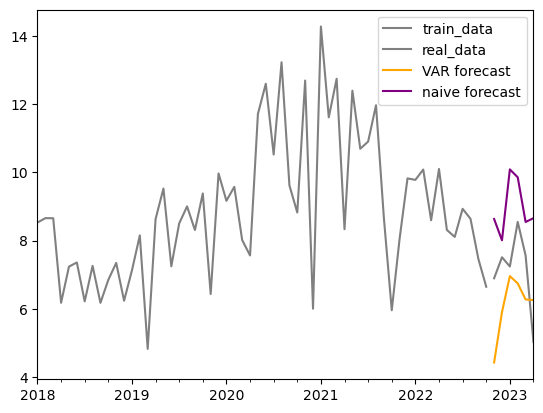

<Figure size 1400x600 with 0 Axes>

In [339]:
# number of data splits = 5
# number of future forecasts = 6
# depth of our VAR model = 4
MSE_var = np.zeros(5)
MSE_naive = np.zeros(5)
pred_VAR = np.zeros(num_forecast)
pred_naive = np.zeros(num_forecast)
count = 0
depth_VAR = 5
depth_naive = 5 #this is the number of years the naive model considers (and takes the seasonal average over)
for train_index, test_index in kfold.split(combined_data):
    var_model = VAR(combined_data.iloc[train_index])
    #This version specifies the VAR depth by hand
    #var_results = var_model.fit(depth_VAR)
    #This version chooses the appropriate VAR depth by optimization
    var_results = var_model.fit(maxlags=5, ic='aic')
    lag_order = var_results.k_ar  # = depth_VAR for us

    #print(combined_data.iloc[train_index])
    #print(combined_data.iloc[test_index])
    #print(lag_order)
    #print(combined_data.iloc[train_index].iloc[-lag_order:])
    #print(depth_VAR)
    print('forecast')
    print(var_results.forecast(combined_data.iloc[train_index].iloc[-lag_order:].values,num_forecast)) #5 is the index of 'recall'
    pred_VAR = var_results.forecast(combined_data.iloc[train_index].iloc[-lag_order:].values,num_forecast)[:,5]
    pred_index = 0                
    for i in test_index:
        pred_naive[pred_index] = combined_data.iloc[max(i-12*(depth_naive-1),0):i:12]['recall'].mean()
        pred_index += 1
    print('pred_var')
    print(pred_VAR)
    print('actual data')
    print(combined_data.iloc[test_index]['recall'])
    MSE_var[count] = mse(pred_VAR, combined_data.iloc[test_index]['recall'])
    MSE_naive[count] = mse(pred_naive, combined_data.iloc[test_index]['recall'])






# visualization for one of the kfold splits
    if count==0:
        fig, ax = plt.subplots()
        plt.figure(figsize=(14, 6))
        timeframe_test = timeframe[test_index]
        timeframe_train = timeframe[train_index]

# Plot training data
        
        df1 = pd.DataFrame(
             combined_data.iloc[train_index]['recall'].values, columns=['train_data'],
             index=timeframe_train
        )
        df1.plot(ax=ax, color='gray')


# Plot test actual
        df2 = pd.DataFrame(
             combined_data.iloc[test_index]['recall'].values, columns=['real_data'],
             index=timeframe_test
        )
        df2.plot(ax=ax, color='gray')

# Plot test forecast
        df3 = pd.DataFrame(
             pred_VAR, columns=['VAR forecast'],
             index=timeframe_test
        )
        df4 = pd.DataFrame(
             pred_naive, columns=['naive forecast'],
             index=timeframe_test
        )
        df3.plot(ax=ax,color='orange')
        df4.plot(ax=ax,color='purple')


    count += 1

# printing the MSE of the two models
print()
print('mse_naive')
print(MSE_naive)
print('mse_VAR')
print(MSE_var)

(Step 6): experimenting the performance of VAR when we manually add the recall data of the same season from the previous year (for the first year, we fill in the number 8, since this is just an experiment).

In [340]:
#the following array is roughly the recall percentage data with one year lag.
prev_recall_array = np.ones(len(combined_data))*8
# this number here is randomly chosen, based on apparent overall average
prev_recall_array[12:] = combined_data.iloc[:-12]['recall'].values
print(prev_recall_array)
print()
print(combined_data['recall'][:15])
print(combined_data['recall'][-15:])


[ 8.          8.          8.          8.          8.          8.
  8.          8.          8.          8.          8.          8.
  8.52974186  8.65892291  8.65561694  6.17408907  7.23488603  7.35751295
  6.21531632  7.25868726  6.17283951  6.84769776  7.34463277  6.23409669
  7.12530713  8.15217391  4.82051282  8.6306099   9.52890792  7.24489796
  8.50376749  9.0034965   8.31074977  9.38337802  6.43127364  9.97191011
  9.16767189  9.57810718  8.01603206  7.56302521 11.71875    12.60504202
 10.52631579 13.23529412  9.62199313  8.82352941 12.6984127   6.
 14.28571429 11.61825726 12.75167785  8.33333333 12.40105541 10.69609508
 10.90670171 11.97339246  8.66290019  5.95482546  8.0620155   9.82567353
  9.7826087  10.08547009  8.59630033 10.10248902  8.31202046  8.10810811
  8.93300248  8.6407767   7.46268657  6.64505673  6.89252336  7.51104566
  7.2386059   8.5492228   7.56302521  5.02283105  5.69358178  5.97402597
  6.00203459  7.71349862  7.47493163  6.62358643  8.25174825  7.39495798
  

In [341]:
#new data set including the above new lagged data
combined_data_season = combined_data.copy() 
combined_data_season['prev_recall'] = prev_recall_array
print(combined_data_season)

    Campylobacter   STEC  Salmonella  Shigella  Vibrio    recall  prev_recall
0           143.0  246.0      1487.0      68.0     3.0  8.529742     8.000000
1           125.0  188.0      1307.0      61.0     3.0  8.658923     8.000000
2           125.0  297.0      1538.0      61.0     3.0  8.655617     8.000000
3           132.0  333.0      1564.0      58.0     3.0  6.174089     8.000000
4           167.0  370.0      1882.0      56.0    10.0  7.234886     8.000000
..            ...    ...         ...       ...     ...       ...          ...
83          143.0  374.0      1759.0      78.0    11.0  9.337349     7.394958
84          144.0  440.0      1563.0      80.0     4.0  8.310992     7.849294
85          146.0  330.0      1383.0      79.0    10.0  8.050847     7.335907
86          149.0  463.0      1508.0      81.0    10.0  7.468477     6.498545
87           75.0  289.0      1222.0      62.0     5.0  6.285178     6.718062

[88 rows x 7 columns]


forecast
[[ 1.36051890e+02  1.52184400e+02  1.54515361e+03  5.07279272e+01
   1.26437433e+00  6.05919944e+00  1.01206983e+01]
 [ 1.24620488e+02  1.63370349e+02  1.43417791e+03  3.54297156e+01
   4.81422164e+00  6.38472399e+00  6.22347329e+00]
 [ 1.60898456e+02  1.58115407e+02  1.32220817e+03  4.59473591e+01
  -6.00804895e-01  9.94053530e+00  1.12320216e+01]
 [ 1.53684230e+02  1.74998184e+02  1.17142669e+03  3.93975304e+01
   6.87346038e+00  8.73125113e+00  8.60233791e+00]
 [ 1.84619219e+02  2.03281116e+02  1.38830588e+03  3.97267710e+01
   5.48066142e+00  8.89009835e+00  6.93843282e+00]
 [ 1.83970639e+02  3.06602108e+02  1.51646854e+03  4.21941192e+01
   3.51701272e+00  8.80475644e+00  1.02503390e+01]]
pred_new_var
[6.05919944 6.38472399 9.9405353  8.73125113 8.89009835 8.80475644]
actual data
58    6.892523
59    7.511046
60    7.238606
61    8.549223
62    7.563025
63    5.022831
Name: recall, dtype: float64
forecast
[[ 170.37895752  501.65776383 1950.8145561    83.46092856   18.7774

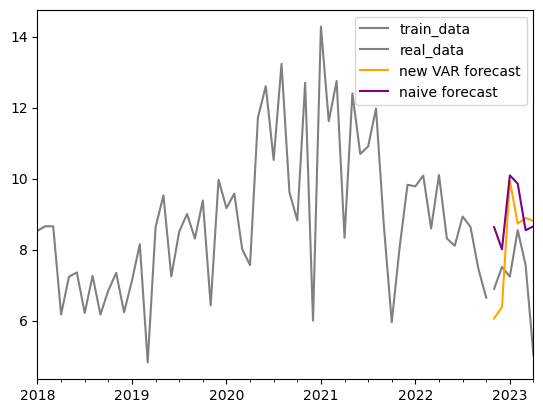

<Figure size 1400x600 with 0 Axes>

In [342]:
# number of data splits = 5
# number of future forecasts = 6
# depth of our VAR model = 4
MSE_new_var = np.zeros(5)
MSE_naive = np.zeros(5)
pred_new_VAR = np.zeros(num_forecast)
pred_naive = np.zeros(num_forecast)
count = 0 # this is the index of the current testing in the kfold split
depth_new_VAR = 5
depth_naive = 5 #this is the number of years the naive model considers (and takes the seasonal average over)
for train_index, test_index in kfold.split(combined_data_season):
    new_var_model = VAR(combined_data_season.iloc[train_index])
    #This version specifies the VAR depth by hand
    #var_results = var_model.fit(depth_VAR)
    #This version chooses the appropriate VAR depth by optimization
    new_var_results = new_var_model.fit(maxlags=5, ic='aic')
    lag_order = new_var_results.k_ar  # = depth_VAR for us
    print('forecast')
    print(new_var_results.forecast(combined_data_season.iloc[train_index].iloc[-lag_order:].values,num_forecast)) #5 is the index of 'recall'
    pred_new_VAR = new_var_results.forecast(combined_data_season.iloc[train_index].iloc[-lag_order:].values,num_forecast)[:,5]
    pred_index = 0                
    for i in test_index:
        pred_naive[pred_index] = combined_data.iloc[max(i-12*(depth_naive-1),0):i:12]['recall'].mean()
        pred_index += 1
    print('pred_new_var')
    print(pred_new_VAR)
    print('actual data')
    print(combined_data.iloc[test_index]['recall'])
    MSE_new_var[count] = mse(pred_new_VAR, combined_data.iloc[test_index]['recall'])
    MSE_naive[count] = mse(pred_naive, combined_data.iloc[test_index]['recall'])






# visualization for one of the kfold splits
    if count==0:
        fig, ax = plt.subplots()
        plt.figure(figsize=(14, 6))
        timeframe_test = timeframe[test_index]
        timeframe_train = timeframe[train_index]

# Plot training data
        
        df1 = pd.DataFrame(
             combined_data.iloc[train_index]['recall'].values, columns=['train_data'],
             index=timeframe_train
        )
        df1.plot(ax=ax, color='gray')


# Plot test actual
        df2 = pd.DataFrame(
             combined_data.iloc[test_index]['recall'].values, columns=['real_data'],
             index=timeframe_test
        )
        df2.plot(ax=ax, color='gray')

# Plot test forecast
        df3 = pd.DataFrame(
             pred_new_VAR, columns=['new VAR forecast'],
             index=timeframe_test
        )
        df4 = pd.DataFrame(
             pred_naive, columns=['naive forecast'],
             index=timeframe_test
        )
        df3.plot(ax=ax,color='orange')
        df4.plot(ax=ax,color='purple')


    count += 1

# printing the MSE of the two models
print()
print('mse_naive')
print(MSE_naive)
print('mse_new_VAR')
print(MSE_new_var)

We see that including this new variable improves the performance (because the data has seasonality).

Step 7: Finalalized VAR model where we add the ``season average of the past three years.'' This is expected to improve the original VAR model due to seasonality,

[ 8.52974186  8.65892291  8.65561694  6.17408907  7.23488603  7.35751295
  6.21531632  7.25868726  6.17283951  6.84769776  7.34463277  6.23409669
  7.82752449  8.40554841  6.73806488  7.40234948  8.38189697  7.30120546
  7.3595419   8.13109188  7.24179464  8.11553789  6.88795321  8.1030034
  8.27424029  8.79640134  7.16405394  7.45590806  9.49418132  9.06915098
  8.4151332   9.83249263  8.03519414  8.35153506  8.82477304  7.40200227
 10.19289777  9.78284612  8.52940758  8.17565615 11.21623778 10.18201168
  9.97892833 11.40406103  8.86521436  8.05391096  9.06390062  8.59919455
 11.07866496 10.42727818  9.78800341  8.66628252 10.81060862 10.4697484
 10.12200666 11.28315443  8.58252663  7.1411372   9.21765052  7.7789064
 10.43564296 10.08431671  9.63700113  7.81955113  8.80221922  8.25940972
  8.61391293  9.44255593  7.86683946  6.40782287  7.73542904  8.24389239
  8.29016939  8.65686674  7.55262355  7.28112725  7.35614316  7.44088953
  7.58015564  8.24993257  7.52420917  7.2585292   7.30

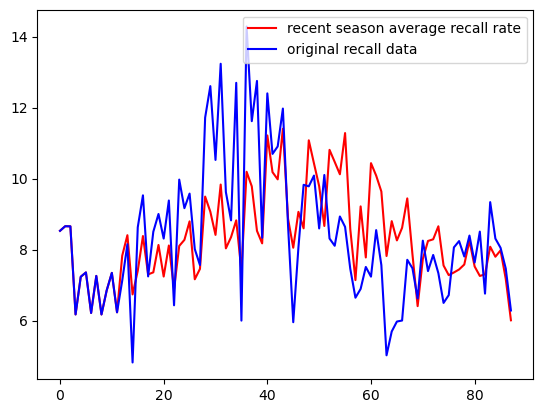

In [344]:
recent_avg_recall_array = np.zeros(len(combined_data)) # this will be the ``recent season average of recall percentage''
for i in range(len(combined_data)):
    indices = [i - 12 * j for j in range(3) if i - 12 * j >= 0]
    recall_values = combined_data.loc[indices, 'recall']
    recent_avg_recall_array[i] = recall_values.mean() if not recall_values.empty else 0

plt.plot(recent_avg_recall_array,color='red',label='recent season average recall rate')
plt.plot(combined_data['recall'],color='blue',label='original recall data')
plt.legend()
print(recent_avg_recall_array)
print()
print(combined_data['recall'])

In [345]:
#this is the final dataset we will use for the VAR model
combined_data_final = combined_data.copy() 
combined_data_final['recent_season_average_recall'] = recent_avg_recall_array
print(combined_data_final)

    Campylobacter   STEC  Salmonella  Shigella  Vibrio    recall  \
0           143.0  246.0      1487.0      68.0     3.0  8.529742   
1           125.0  188.0      1307.0      61.0     3.0  8.658923   
2           125.0  297.0      1538.0      61.0     3.0  8.655617   
3           132.0  333.0      1564.0      58.0     3.0  6.174089   
4           167.0  370.0      1882.0      56.0    10.0  7.234886   
..            ...    ...         ...       ...     ...       ...   
83          143.0  374.0      1759.0      78.0    11.0  9.337349   
84          144.0  440.0      1563.0      80.0     4.0  8.310992   
85          146.0  330.0      1383.0      79.0    10.0  8.050847   
86          149.0  463.0      1508.0      81.0    10.0  7.468477   
87           75.0  289.0      1222.0      62.0     5.0  6.285178   

    recent_season_average_recall  
0                       8.529742  
1                       8.658923  
2                       8.655617  
3                       6.174089  
4       


0 -th k-fold split
VAR lag order used here is: 5
forecast of all the variables used here:
[[ 159.0295035   243.41543392 1868.46783743   61.46558058   12.38227274
     4.10538855    8.86747402]
 [ 138.63359474  248.12897091 1563.04046798   49.09703939    8.57777457
     5.74861815    6.81370366]
 [ 190.41915715  288.36039269 1583.81619473   61.39522739   16.68874681
     7.35544473   10.21628926]
 [ 169.4700928   221.72675043 1301.56809984   59.5226511    14.40982204
     6.7779889     8.06387731]
 [ 169.37581473  242.70851358 1299.31246043   50.6524333     6.06029037
     5.90181728    6.69928442]
 [ 205.42652881  345.17041631 1587.34437316   60.51601071    3.1722414
     6.1677378     9.00772191]]
pred_final_var:
[4.10538855 5.74861815 7.35544473 6.7779889  5.90181728 6.1677378 ]
actual data:
58    6.892523
59    7.511046
60    7.238606
61    8.549223
62    7.563025
63    5.022831
Name: recall, dtype: float64

1 -th k-fold split
VAR lag order used here is: 5
forecast of all the varia

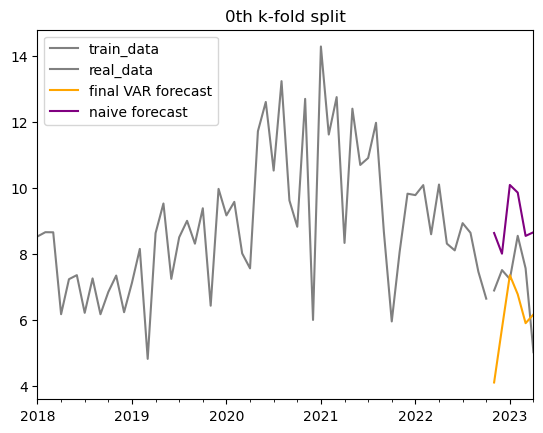

<Figure size 1400x600 with 0 Axes>

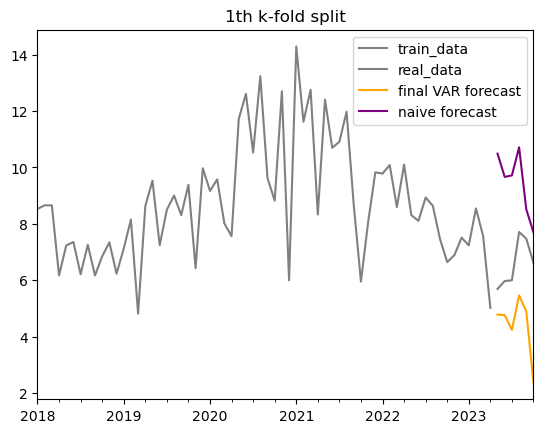

<Figure size 1400x600 with 0 Axes>

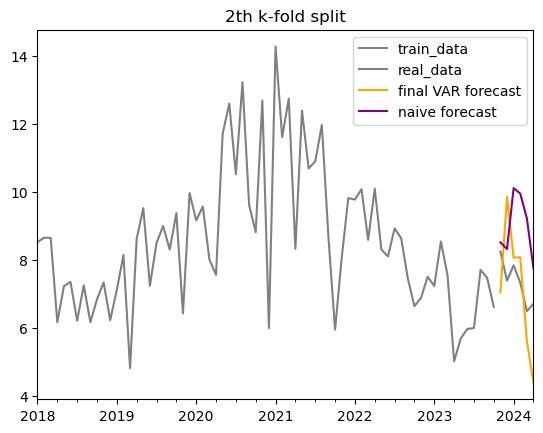

<Figure size 1400x600 with 0 Axes>

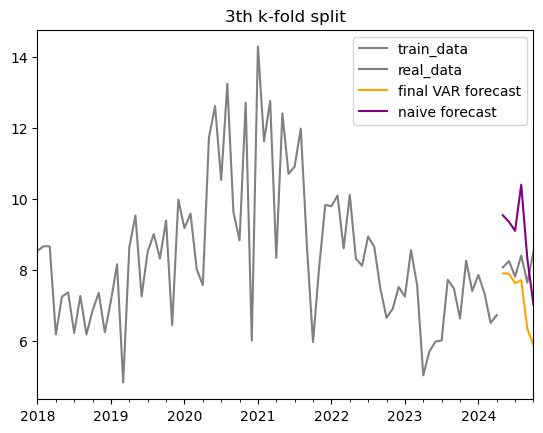

<Figure size 1400x600 with 0 Axes>

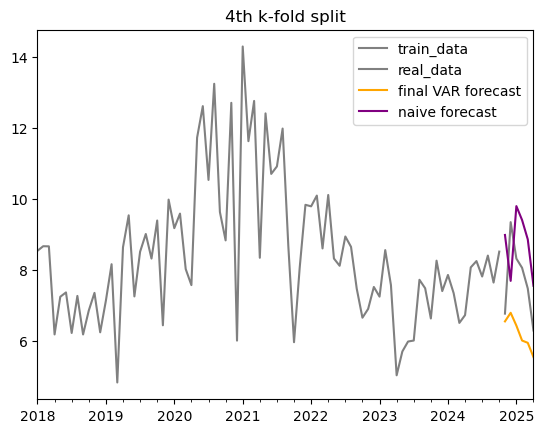

<Figure size 1400x600 with 0 Axes>

In [346]:
# number of data splits = 5
# number of future forecasts = 6
# maximum depth of our VAR model = 5 
MSE_final_var = np.zeros(5)
MSE_naive = np.zeros(5)
pred_final_VAR = np.zeros(num_forecast)
pred_naive = np.zeros(num_forecast)
count = 0 # current index of the kfod split
depth_final_VAR_max = 5
depth_naive = 5 #this is the number of years the naive model considers (and takes the seasonal average over)
for train_index, test_index in kfold.split(combined_data_final):
    final_var_model = VAR(combined_data_final.iloc[train_index])
    #This version specifies the VAR depth by hand
    #var_results = var_model.fit(depth_VAR)
    #This version chooses the appropriate VAR depth by optimization
    final_var_results = final_var_model.fit(maxlags=depth_final_VAR_max, ic='aic')
    lag_order = final_var_results.k_ar  # = depth_VAR for us
    print()
    print(count, '-th k-fold split')
    print('VAR lag order used here is:', lag_order)
    print('forecast of all the variables used here:')
    print(final_var_results.forecast(combined_data_final.iloc[train_index].iloc[-lag_order:].values,num_forecast)) #5 is the index of 'recall'
    pred_final_VAR = final_var_results.forecast(combined_data_final.iloc[train_index].iloc[-lag_order:].values,num_forecast)[:,5]
    pred_index = 0                
    for i in test_index:
        pred_naive[pred_index] = combined_data.iloc[max(i-12*(depth_naive-1),0):i:12]['recall'].mean()
        pred_index += 1
    print('pred_final_var:')
    print(pred_final_VAR)
    print('actual data:')
    print(combined_data.iloc[test_index]['recall'])
    MSE_final_var[count] = mse(pred_final_VAR, combined_data.iloc[test_index]['recall'])
    MSE_naive[count] = mse(pred_naive, combined_data.iloc[test_index]['recall'])


# visualization for one of the kfold splits
    if count<5:
        
        fig, ax = plt.subplots()
        plt.figure(figsize=(14, 6))
        ax.set_title(str(count)+'th k-fold split')
        timeframe_test = timeframe[test_index]
        timeframe_train = timeframe[train_index]

# Plot training data
        
        df1 = pd.DataFrame(
             combined_data.iloc[train_index]['recall'].values, columns=['train_data'],
             index=timeframe_train
        )
        df1.plot(ax=ax, color='gray')


# Plot test actual
        df2 = pd.DataFrame(
             combined_data.iloc[test_index]['recall'].values, columns=['real_data'],
             index=timeframe_test
        )
        df2.plot(ax=ax, color='gray')

# Plot test forecast
        df3 = pd.DataFrame(
             pred_final_VAR, columns=['final VAR forecast'],
             index=timeframe_test
        )
        df4 = pd.DataFrame(
             pred_naive, columns=['naive forecast'],
             index=timeframe_test
        )
        df3.plot(ax=ax,color='orange')
        df4.plot(ax=ax,color='purple')


    count += 1

# printing the MSE of the two models
print()
print('mse_naive')
print(MSE_naive)
print('mse_final_VAR')
print(MSE_final_var)